In [ ]:
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from bintree import (
    ForwardBinomialTree,
    call_payoff,
    put_payoff,
    digital_call_payoff
)

In [94]:
# Download available option maturities for a stock ticker
ticker = "NVDA"
stock = yf.Ticker(ticker)

# Get available expiration dates
expirations = stock.options
print(f"Available option maturities for {ticker}:")
for exp in expirations:
    print(f"  {exp}")

Available option maturities for NVDA:
  2026-01-16
  2026-01-23
  2026-01-30
  2026-02-06
  2026-02-13
  2026-02-20
  2026-02-27
  2026-03-20
  2026-04-17
  2026-05-15
  2026-06-18
  2026-07-17
  2026-08-21
  2026-09-18
  2026-11-20
  2026-12-18
  2027-01-15
  2027-06-17
  2027-09-17
  2027-12-17
  2028-01-21
  2028-12-15


In [ ]:
from datetime import datetime, timedelta
from zoneinfo import ZoneInfo

# Get current stock price and download timestamp
current_price = stock.info['currentPrice']
download_timestamp = datetime.now(ZoneInfo('America/New_York'))

# Market hours: 9:30 AM - 4:00 PM ET, weekdays only
market_open = download_timestamp.replace(hour=9, minute=30, second=0, microsecond=0)
market_close = download_timestamp.replace(hour=16, minute=0, second=0, microsecond=0)
is_weekday = download_timestamp.weekday() < 5  # Monday=0, Friday=4

# Determine data timestamp based on when we query
if is_weekday and market_open <= download_timestamp <= market_close:
    # During trading hours: data is delayed by 15 minutes
    data_timestamp = download_timestamp - timedelta(minutes=15)
    timestamp_note = "During market hours - 15 min delay applied"
else:
    # After hours / weekend: data reflects market close
    if download_timestamp < market_open and is_weekday:
        # Before market open on a weekday - use previous trading day's close
        days_back = 1 if download_timestamp.weekday() != 0 else 3  # Monday -> Friday
        data_timestamp = (download_timestamp - timedelta(days=days_back)).replace(
            hour=16, minute=0, second=0, microsecond=0)
        timestamp_note = "Before market open - using previous close"
    elif not is_weekday:
        # Weekend - use Friday's close
        days_back = download_timestamp.weekday() - 4  # Days since Friday
        data_timestamp = (download_timestamp - timedelta(days=days_back)).replace(
            hour=16, minute=0, second=0, microsecond=0)
        timestamp_note = "Weekend - using Friday's close"
    else:
        # After market close on a weekday
        data_timestamp = market_close
        timestamp_note = "After market close - using today's close"

print(f"Current price of {ticker}: ${current_price:.2f}")
print(f"Download time (ET): {download_timestamp.strftime('%Y-%m-%d %H:%M:%S %Z')}")
print(f"Data timestamp (ET): {data_timestamp.strftime('%Y-%m-%d %H:%M:%S %Z')}")
print(f"Note: {timestamp_note}")

# Select an expiration date
selected_expiration = expirations[5]  # Change index to select different expiration
print(f"\nSelected expiration: {selected_expiration}")

# Download option chain for selected expiration
option_chain = stock.option_chain(selected_expiration)

# Option chain contains calls and puts DataFrames
calls = option_chain.calls
puts = option_chain.puts

print(f"\nCalls ({len(calls)} contracts):")
display(calls.head())

print(f"\nPuts ({len(puts)} contracts):")
display(puts.head())

In [ ]:
# Options expire at 4pm ET on the expiration date
expiration_date = datetime.strptime(selected_expiration, '%Y-%m-%d')
expiration_datetime_et = expiration_date.replace(hour=16, minute=0, second=0, tzinfo=ZoneInfo('America/New_York'))

# data_timestamp is already in ET from previous cell

# Calculate time to expiration in years
time_to_expiration = expiration_datetime_et - data_timestamp
T_years = time_to_expiration.total_seconds() / (365.25 * 24 * 60 * 60)

print(f"Expiration: {expiration_datetime_et.strftime('%Y-%m-%d %H:%M %Z')}")
print(f"Data timestamp: {data_timestamp.strftime('%Y-%m-%d %H:%M:%S %Z')}")
print(f"Time to expiration: {time_to_expiration}")
print(f"Time to expiration (years): {T_years:.6f}")

In [97]:
# Download last year of dividend data
one_year_ago = data_timestamp - timedelta(days=365)
dividends = stock.dividends

# Filter to last year
dividends_last_year = dividends[dividends.index >= one_year_ago.strftime('%Y-%m-%d')]

print(f"Dividends for {ticker} over the last year:")
print(dividends_last_year)
print(f"\nTotal dividends: ${dividends_last_year.sum():.4f}")
print(f"Number of payments: {len(dividends_last_year)}")

Dividends for NVDA over the last year:
Date
2025-03-12 00:00:00-04:00    0.01
2025-06-11 00:00:00-04:00    0.01
2025-09-11 00:00:00-04:00    0.01
2025-12-04 00:00:00-05:00    0.01
Name: Dividends, dtype: float64

Total dividends: $0.0400
Number of payments: 4


In [98]:
# Add time-to-expiration to option DataFrames
calls['T'] = T_years
puts['T'] = T_years

# Calculate continuously compounded dividend yield
# Annual dividend / current price gives simple yield
# Continuous yield: q = ln(1 + D/S) ≈ D/S for small yields
annual_dividends = dividends_last_year.sum()
simple_div_yield = annual_dividends / current_price
div_yield = np.log(1 + simple_div_yield)  # Continuously compounded

print(f"Annual dividends: ${annual_dividends:.4f}")
print(f"Current price: ${current_price:.2f}")
print(f"Simple dividend yield: {simple_div_yield:.4%}")
print(f"Continuously compounded dividend yield: {div_yield:.4%}")

# Add dividend yield to option DataFrames
calls['div_yield'] = div_yield
puts['div_yield'] = div_yield

print(f"\nCalls DataFrame columns: {list(calls.columns)}")
print(f"Puts DataFrame columns: {list(puts.columns)}")

Annual dividends: $0.0400
Current price: $183.14
Simple dividend yield: 0.0218%
Continuously compounded dividend yield: 0.0218%

Calls DataFrame columns: ['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask', 'change', 'percentChange', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'contractSize', 'currency', 'T', 'div_yield']
Puts DataFrame columns: ['contractSymbol', 'lastTradeDate', 'strike', 'lastPrice', 'bid', 'ask', 'change', 'percentChange', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'contractSize', 'currency', 'T', 'div_yield']


In [99]:
import pandas_datareader.data as web

# Download latest overnight SOFR rate from FRED
start_date = (data_timestamp - timedelta(days=7)).strftime('%Y-%m-%d')
end_date = data_timestamp.strftime('%Y-%m-%d')

sofr_data = web.DataReader('SOFR', 'fred', start_date, end_date)
rf = sofr_data.iloc[-1, 0] / 100  # Convert from percentage

print(f"Latest SOFR rate: {rf:.4%}")
print(f"As of: {sofr_data.index[-1].strftime('%Y-%m-%d')}")

# Add to option DataFrames
calls['rf'] = rf
puts['rf'] = rf

Latest SOFR rate: 3.6500%
As of: 2026-01-13


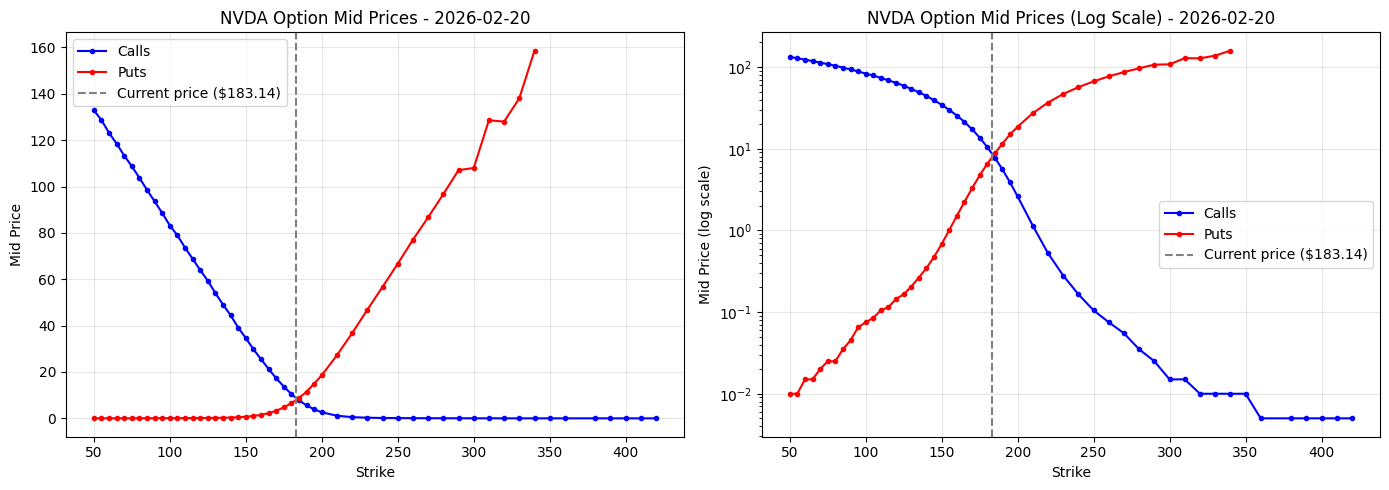

In [100]:
# Calculate mid prices as average of bid and ask
calls['mid'] = (calls['bid'] + calls['ask']) / 2
puts['mid'] = (puts['bid'] + puts['ask']) / 2

# Plot 1: Standard scale
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(calls['strike'], calls['mid'], 'b.-', label='Calls')
axes[0].plot(puts['strike'], puts['mid'], 'r.-', label='Puts')
axes[0].axvline(current_price, color='gray', linestyle='--', label=f'Current price (${current_price:.2f})')
axes[0].set_xlabel('Strike')
axes[0].set_ylabel('Mid Price')
axes[0].set_title(f'{ticker} Option Mid Prices - {selected_expiration}')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Log scale (y-axis)
axes[1].plot(calls['strike'], calls['mid'], 'b.-', label='Calls')
axes[1].plot(puts['strike'], puts['mid'], 'r.-', label='Puts')
axes[1].axvline(current_price, color='gray', linestyle='--', label=f'Current price (${current_price:.2f})')
axes[1].set_xlabel('Strike')
axes[1].set_ylabel('Mid Price (log scale)')
axes[1].set_yscale('log')
axes[1].set_title(f'{ticker} Option Mid Prices (Log Scale) - {selected_expiration}')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [101]:
# Filter for out-of-the-money options
# OTM calls: strike > current price
# OTM puts: strike < current price

otm_calls = calls[calls['strike'] > current_price].copy()
otm_puts = puts[puts['strike'] < current_price].copy()

print(f"Current price: ${current_price:.2f}")
print(f"\nOTM Calls ({len(otm_calls)} contracts) - Strike > ${current_price:.2f}:")
display(otm_calls)

print(f"\nOTM Puts ({len(otm_puts)} contracts) - Strike < ${current_price:.2f}:")
display(otm_puts)

Current price: $183.14

OTM Calls (25 contracts) - Strike > $183.14:


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,T,div_yield,rf,mid
27,NVDA260220C00185000,2026-01-14 20:59:38+00:00,185.0,7.77,7.75,7.80,-1.58,-17.025866,8987,38014,0.367316,False,REGULAR,USD,0.101265,0.000218,0.0365,7.775
28,NVDA260220C00190000,2026-01-14 20:59:55+00:00,190.0,5.57,5.55,5.60,-1.28,-18.740845,13458,54593,0.358222,False,REGULAR,USD,0.101265,0.000218,0.0365,5.575
29,NVDA260220C00195000,2026-01-14 20:59:50+00:00,195.0,3.85,3.85,3.90,-1.05,-21.649487,4249,34806,0.351752,False,REGULAR,USD,0.101265,0.000218,0.0365,3.875
30,NVDA260220C00200000,2026-01-14 20:59:55+00:00,200.0,2.61,2.59,2.62,-0.76,-22.754492,17434,99132,0.346198,False,REGULAR,USD,0.101265,0.000218,0.0365,2.605
31,NVDA260220C00210000,2026-01-14 20:59:55+00:00,210.0,1.13,1.13,1.15,-0.40,-26.143790,12145,87039,0.344855,False,REGULAR,USD,0.101265,0.000218,0.0365,1.140
32,NVDA260220C00220000,2026-01-14 20:59:27+00:00,220.0,0.53,0.52,0.53,-0.16,-23.188408,14493,112987,0.354499,False,REGULAR,USD,0.101265,0.000218,0.0365,0.525
33,NVDA260220C00230000,2026-01-14 20:59:36+00:00,230.0,0.27,0.27,0.29,-0.06,-18.181818,2385,32939,0.375739,False,REGULAR,USD,0.101265,0.000218,0.0365,0.280
34,NVDA260220C00240000,2026-01-14 20:54:25+00:00,240.0,0.16,0.16,0.17,-0.03,-15.789474,414,28355,0.397467,False,REGULAR,USD,0.101265,0.000218,0.0365,0.165
35,NVDA260220C00250000,2026-01-14 20:36:03+00:00,250.0,0.11,0.10,0.11,-0.01,-8.333331,267,27129,0.421881,False,REGULAR,USD,0.101265,0.000218,0.0365,0.105
36,NVDA260220C00260000,2026-01-14 20:29:37+00:00,260.0,0.08,0.07,0.08,0.00,0.000000,333,28899,0.448248,False,REGULAR,USD,0.101265,0.000218,0.0365,0.075



OTM Puts (27 contracts) - Strike < $183.14:


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency,T,div_yield,rf,mid
0,NVDA260220P00050000,2026-01-14 16:44:49+00:00,50.0,0.01,0.00,0.02,0.00,0.000000,1.0,6390,1.296879,False,REGULAR,USD,0.101265,0.000218,0.0365,0.010
1,NVDA260220P00055000,2026-01-14 19:07:00+00:00,55.0,0.02,0.00,0.02,0.01,100.000000,10.0,864,1.203129,False,REGULAR,USD,0.101265,0.000218,0.0365,0.010
2,NVDA260220P00060000,2026-01-13 19:53:55+00:00,60.0,0.01,0.01,0.02,0.00,0.000000,13.0,2089,1.156254,False,REGULAR,USD,0.101265,0.000218,0.0365,0.015
3,NVDA260220P00065000,2026-01-14 20:16:25+00:00,65.0,0.02,0.01,0.02,0.00,0.000000,106.0,714,1.078130,False,REGULAR,USD,0.101265,0.000218,0.0365,0.015
4,NVDA260220P00070000,2026-01-14 20:20:37+00:00,70.0,0.03,0.01,0.03,0.01,50.000000,21.0,1352,1.031255,False,REGULAR,USD,0.101265,0.000218,0.0365,0.020
5,NVDA260220P00075000,2026-01-12 14:54:14+00:00,75.0,0.03,0.02,0.03,0.00,0.000000,5.0,906,0.976563,False,REGULAR,USD,0.101265,0.000218,0.0365,0.025
6,NVDA260220P00080000,2026-01-14 17:58:48+00:00,80.0,0.03,0.02,0.03,-0.01,-25.000000,50.0,1555,0.910157,False,REGULAR,USD,0.101265,0.000218,0.0365,0.025
7,NVDA260220P00085000,2026-01-14 20:29:17+00:00,85.0,0.04,0.03,0.04,0.00,0.000000,52.0,4405,0.875001,False,REGULAR,USD,0.101265,0.000218,0.0365,0.035
8,NVDA260220P00090000,2026-01-14 15:08:33+00:00,90.0,0.06,0.04,0.05,0.01,19.999994,8.0,2322,0.835939,False,REGULAR,USD,0.101265,0.000218,0.0365,0.045
9,NVDA260220P00095000,2026-01-14 20:31:15+00:00,95.0,0.07,0.06,0.07,0.01,16.666670,8.0,3240,0.808596,False,REGULAR,USD,0.101265,0.000218,0.0365,0.065


In [102]:
# Download 12 months of daily price history
end_date_hist = data_timestamp.strftime('%Y-%m-%d')
start_date_hist = (data_timestamp - timedelta(days=365)).strftime('%Y-%m-%d')

hist = stock.history(start=start_date_hist, end=end_date_hist)

# Calculate daily log returns
hist['return'] = hist['Close'] / hist['Close'].shift(1)-1.0

# Estimate volatility (standard deviation of daily returns)
daily_vol = hist['return'].std()

# Annualize volatility (assuming 252 trading days per year)
physical_sigma = daily_vol * np.sqrt(252)

print(f"Historical data: {start_date_hist} to {end_date_hist}")
print(f"Number of trading days: {len(hist)}")
print(f"Daily volatility: {daily_vol:.4%}")
print(f"Annualized volatility (physical_sigma): {physical_sigma:.4%}")

# Add to OTM option tables
otm_calls['physical_sigma'] = physical_sigma
otm_puts['physical_sigma'] = physical_sigma

Historical data: 2025-01-14 to 2026-01-14
Number of trading days: 251
Daily volatility: 3.0699%
Annualized volatility (physical_sigma): 48.7339%


In [103]:
# Price OTM options using binomial tree with different number of periods using historical volatility
periods_list = [5, 37, 200]

# Price OTM calls
for N in periods_list:
    prices = []
    for _, row in otm_calls.iterrows():
        tree = ForwardBinomialTree(
            S0=current_price,
            T_maturity=row['T'],
            N_periods=N,
            sigma=row['physical_sigma'],
            rf=row['rf'],
            div_yld=row['div_yield']
        )
        price = tree.price_american(call_payoff(row['strike']))
        prices.append(price)
    otm_calls[f'bin_{N}'] = prices

# Price OTM puts
for N in periods_list:
    prices = []
    for _, row in otm_puts.iterrows():
        tree = ForwardBinomialTree(
            S0=current_price,
            T_maturity=row['T'],
            N_periods=N,
            sigma=row['physical_sigma'],
            rf=row['rf'],
            div_yld=row['div_yield']
        )
        price = tree.price_american(put_payoff(row['strike']))
        prices.append(price)
    otm_puts[f'bin_{N}'] = prices

print("OTM Calls with binomial prices:")
display(otm_calls[['strike', 'mid', 'bin_5', 'bin_37', 'bin_200']])

print("\nOTM Puts with binomial prices:")
display(otm_puts[['strike', 'mid', 'bin_5', 'bin_37', 'bin_200']])

OTM Calls with binomial prices:


,strike,mid,bin_5,bin_37,bin_200
27,185.0,7.775,11.340783,1.084144e+01,1.078377e+01
28,190.0,5.575,9.011762,8.687147e+00,8.702334e+00
29,195.0,3.875,6.682741,6.981899e+00,6.934209e+00
30,200.0,2.605,5.248743,5.450922e+00,5.456775e+00
31,210.0,1.140,3.589030,3.251162e+00,3.272389e+00
32,220.0,0.525,1.929317,1.837007e+00,1.890111e+00
33,230.0,0.280,0.783106,1.025040e+00,1.048899e+00
34,240.0,0.165,0.522107,5.584862e-01,5.605614e-01
35,250.0,0.105,0.261108,2.895729e-01,2.885904e-01
36,260.0,0.075,0.000109,1.397664e-01,1.466970e-01



OTM Puts with binomial prices:


,strike,mid,bin_5,bin_37,bin_200
0,50.0,0.010,0.000000,0.000000e+00,3.397154e-18
1,55.0,0.010,0.000000,0.000000e+00,1.020942e-15
2,60.0,0.015,0.000000,0.000000e+00,1.393913e-13
3,65.0,0.015,0.000000,0.000000e+00,9.661814e-12
4,70.0,0.020,0.000000,0.000000e+00,2.944785e-10
5,75.0,0.025,0.000000,3.979179e-11,6.466493e-09
6,80.0,0.025,0.000000,7.577593e-09,8.778751e-08
7,85.0,0.035,0.000000,1.804321e-07,8.797372e-07
8,90.0,0.045,0.000000,2.187771e-06,6.789690e-06
9,95.0,0.065,0.000000,1.790395e-05,3.812173e-05


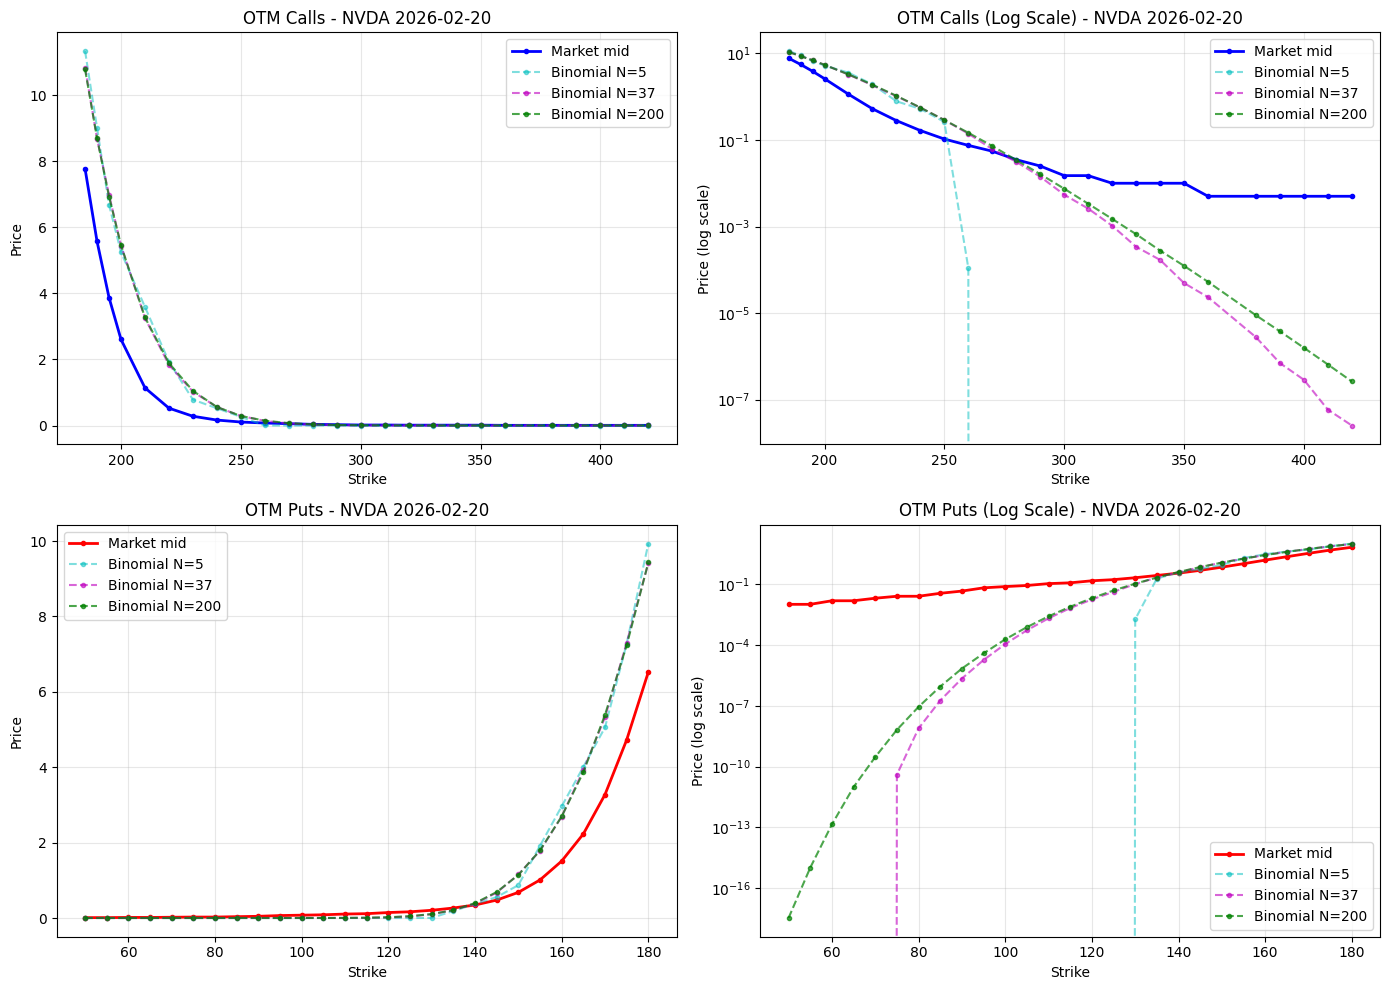

In [104]:
# Plot OTM Calls: observed vs binomial prices
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Calls - Regular scale
axes[0, 0].plot(otm_calls['strike'], otm_calls['mid'], 'b.-', linewidth=2, label='Market mid')
axes[0, 0].plot(otm_calls['strike'], otm_calls['bin_5'], 'c.--', alpha=0.5, label='Binomial N=5')
axes[0, 0].plot(otm_calls['strike'], otm_calls['bin_37'], 'm.--', alpha=0.6, label='Binomial N=37')
axes[0, 0].plot(otm_calls['strike'], otm_calls['bin_200'], 'g.--', alpha=0.7, label='Binomial N=200')
axes[0, 0].set_xlabel('Strike')
axes[0, 0].set_ylabel('Price')
axes[0, 0].set_title(f'OTM Calls - {ticker} {selected_expiration}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Calls - Log scale
axes[0, 1].plot(otm_calls['strike'], otm_calls['mid'], 'b.-', linewidth=2, label='Market mid')
axes[0, 1].plot(otm_calls['strike'], otm_calls['bin_5'], 'c.--', alpha=0.5, label='Binomial N=5')
axes[0, 1].plot(otm_calls['strike'], otm_calls['bin_37'], 'm.--', alpha=0.6, label='Binomial N=37')
axes[0, 1].plot(otm_calls['strike'], otm_calls['bin_200'], 'g.--', alpha=0.7, label='Binomial N=200')
axes[0, 1].set_xlabel('Strike')
axes[0, 1].set_ylabel('Price (log scale)')
axes[0, 1].set_yscale('log')
axes[0, 1].set_title(f'OTM Calls (Log Scale) - {ticker} {selected_expiration}')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Puts - Regular scale
axes[1, 0].plot(otm_puts['strike'], otm_puts['mid'], 'r.-', linewidth=2, label='Market mid')
axes[1, 0].plot(otm_puts['strike'], otm_puts['bin_5'], 'c.--', alpha=0.5, label='Binomial N=5')
axes[1, 0].plot(otm_puts['strike'], otm_puts['bin_37'], 'm.--', alpha=0.6, label='Binomial N=37')
axes[1, 0].plot(otm_puts['strike'], otm_puts['bin_200'], 'g.--', alpha=0.7, label='Binomial N=200')
axes[1, 0].set_xlabel('Strike')
axes[1, 0].set_ylabel('Price')
axes[1, 0].set_title(f'OTM Puts - {ticker} {selected_expiration}')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Puts - Log scale
axes[1, 1].plot(otm_puts['strike'], otm_puts['mid'], 'r.-', linewidth=2, label='Market mid')
axes[1, 1].plot(otm_puts['strike'], otm_puts['bin_5'], 'c.--', alpha=0.5, label='Binomial N=5')
axes[1, 1].plot(otm_puts['strike'], otm_puts['bin_37'], 'm.--', alpha=0.6, label='Binomial N=37')
axes[1, 1].plot(otm_puts['strike'], otm_puts['bin_200'], 'g.--', alpha=0.7, label='Binomial N=200')
axes[1, 1].set_xlabel('Strike')
axes[1, 1].set_ylabel('Price (log scale)')
axes[1, 1].set_yscale('log')
axes[1, 1].set_title(f'OTM Puts (Log Scale) - {ticker} {selected_expiration}')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [89]:
from scipy.optimize import brentq

# Demonstration: Calculate implied volatility for the first OTM call (lowest strike)
option = otm_calls.iloc[0]

print("Option details:")
print(f"  Strike: ${option['strike']:.2f}")
print(f"  Market mid price: ${option['mid']:.4f}")
print(f"  Physical sigma: {option['physical_sigma']:.4%}")
print(f"  T: {option['T']:.4f} years")
print(f"  rf: {option['rf']:.4%}")
print(f"  div_yield: {option['div_yield']:.4%}")

# Define pricing function as a function of sigma
def binomial_price(sigma, S0, K, T, rf, div_yld, N=200):
    tree = ForwardBinomialTree(
        S0=S0,
        T_maturity=T,
        N_periods=N,
        sigma=sigma,
        rf=rf,
        div_yld=div_yld
    )
    return tree.price_american(call_payoff(K))

# Define objective: difference between model price and market price
def price_difference(sigma):
    model_price = binomial_price(
        sigma=sigma,
        S0=current_price,
        K=option['strike'],
        T=option['T'],
        rf=option['rf'],
        div_yld=option['div_yield'],
        N=200
    )
    return model_price - option['mid']

# Solve for implied volatility using Brent's method
# Search between 1% and 500% volatility
try:
    implied_vol = brentq(price_difference, 0.01, 5.0)
    
    # Verify the result
    model_price_at_iv = binomial_price(
        sigma=implied_vol,
        S0=current_price,
        K=option['strike'],
        T=option['T'],
        rf=option['rf'],
        div_yld=option['div_yield'],
        N=200
    )
    
    print(f"\nImplied volatility calculation:")
    print(f"  Implied volatility: {implied_vol:.4%}")
    print(f"  Model price at IV: ${model_price_at_iv:.4f}")
    print(f"  Market mid price: ${option['mid']:.4f}")
    print(f"  Difference: ${abs(model_price_at_iv - option['mid']):.6f}")
except ValueError as e:
    print(f"\nCould not find implied volatility: {e}")

Option details:
  Strike: $185.00
  Market mid price: $7.2250
  Physical sigma: 48.7339%
  T: 0.1015 years
  rf: 3.6500%
  div_yield: 0.0220%

Implied volatility calculation:
  Implied volatility: 36.0931%
  Model price at IV: $7.2250
  Market mid price: $7.2250
  Difference: $0.000000


In [90]:
# Calculate implied volatility for all OTM options

def calc_implied_vol(row, option_type='call', N=200):
    """Calculate implied volatility for a single option."""
    payoff = call_payoff(row['strike']) if option_type == 'call' else put_payoff(row['strike'])
    
    def price_diff(sigma):
        tree = ForwardBinomialTree(
            S0=current_price,
            T_maturity=row['T'],
            N_periods=N,
            sigma=sigma,
            rf=row['rf'],
            div_yld=row['div_yield']
        )
        return tree.price_american(payoff) - row['mid']
    
    try:
        return brentq(price_diff, 0.01, 5.0)
    except ValueError:
        return np.nan

# Calculate IV for OTM calls
print("Calculating implied volatility for OTM calls...")
otm_calls['iv'] = otm_calls.apply(lambda row: calc_implied_vol(row, 'call'), axis=1)

# Calculate IV for OTM puts
print("Calculating implied volatility for OTM puts...")
otm_puts['iv'] = otm_puts.apply(lambda row: calc_implied_vol(row, 'put'), axis=1)

print("\nOTM Calls with implied volatility:")
display(otm_calls[['strike', 'mid', 'physical_sigma', 'iv']])

print("\nOTM Puts with implied volatility:")
display(otm_puts[['strike', 'mid', 'physical_sigma', 'iv']])

Calculating implied volatility for OTM calls...
Calculating implied volatility for OTM puts...

OTM Calls with implied volatility:


,strike,mid,physical_sigma,iv
27,185.0,7.225,0.487339,0.360931
28,190.0,5.125,0.487339,0.352546
29,195.0,3.575,0.487339,0.349879
30,200.0,2.380,0.487339,0.345284
31,210.0,1.075,0.487339,0.349572
32,220.0,0.515,0.487339,0.362452
33,230.0,0.275,0.487339,0.382125
34,240.0,0.165,0.487339,0.406396
35,250.0,0.105,0.487339,0.429138
36,260.0,0.075,0.487339,0.455433



OTM Puts with implied volatility:


,strike,mid,physical_sigma,iv
0,50.0,0.005,0.487339,1.243726
1,55.0,0.010,0.487339,1.217574
2,60.0,0.015,0.487339,1.172018
3,65.0,0.015,0.487339,1.091267
4,70.0,0.020,0.487339,1.039842
5,75.0,0.025,0.487339,0.990270
6,80.0,0.035,0.487339,0.951788
7,85.0,0.045,0.487339,0.908282
8,90.0,0.055,0.487339,0.863831
9,95.0,0.065,0.487339,0.816692


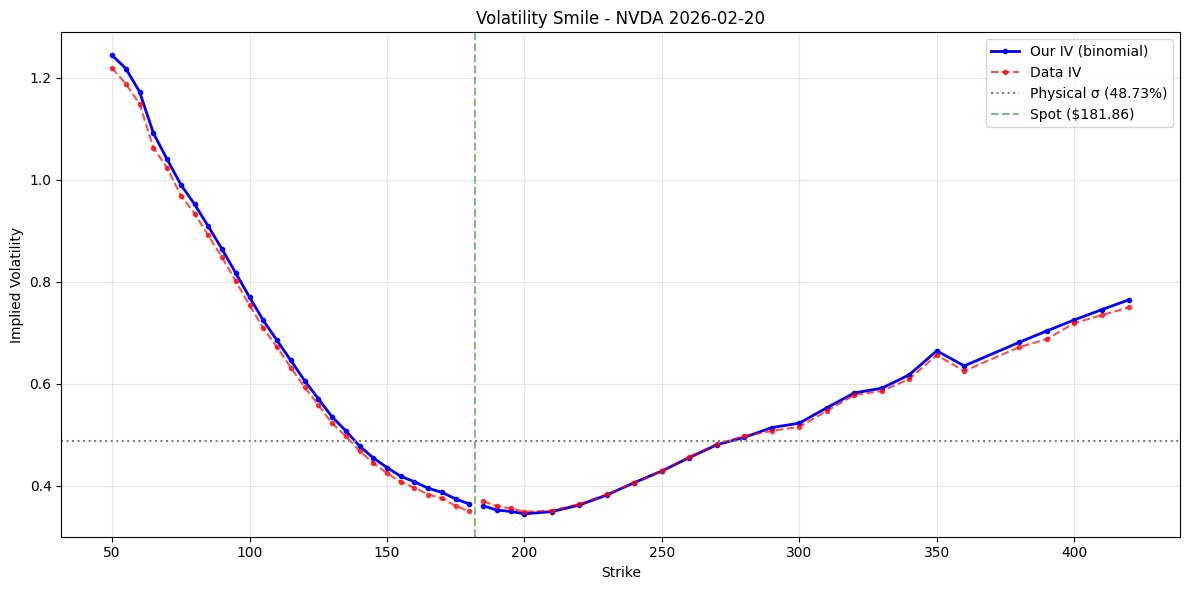

In [91]:
# Plot implied volatility: our calculation vs data source (combined)
fig, ax = plt.subplots(figsize=(12, 6))

# OTM Puts (left side of smile)
ax.plot(otm_puts['strike'], otm_puts['iv'], 'b.-', linewidth=2, label='Our IV (binomial)')
ax.plot(otm_puts['strike'], otm_puts['impliedVolatility'], 'r.--', alpha=0.7, label='Data IV')

# OTM Calls (right side of smile)
ax.plot(otm_calls['strike'], otm_calls['iv'], 'b.-', linewidth=2)
ax.plot(otm_calls['strike'], otm_calls['impliedVolatility'], 'r.--', alpha=0.7)

# Reference lines
ax.axhline(otm_calls['physical_sigma'].iloc[0], color='gray', linestyle=':', label=f'Physical σ ({otm_calls["physical_sigma"].iloc[0]:.2%})')
ax.axvline(current_price, color='green', linestyle='--', alpha=0.5, label=f'Spot (${current_price:.2f})')

ax.set_xlabel('Strike')
ax.set_ylabel('Implied Volatility')
ax.set_title(f'Volatility Smile - {ticker} {selected_expiration}')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [92]:
# Use the implied volatility of the first OTM call to build a tree
# and calculate risk-neutral probabilities of various price outcomes

first_call = otm_calls.iloc[0]
iv = first_call['iv']

print(f"First OTM call option:")
print(f"  Strike: ${first_call['strike']:.2f}")
print(f"  Implied volatility: {iv:.4%}")

# Create 200-step binomial tree with implied volatility
tree = ForwardBinomialTree(
    S0=current_price,
    T_maturity=first_call['T'],
    N_periods=200,
    sigma=iv,
    rf=first_call['rf'],
    div_yld=first_call['div_yield']
)

# Calculate probabilities at each node
tree.calculate_probabilities()

# Get terminal nodes (at maturity)
terminal_period = tree.N_periods
terminal_nodes = tree.tree[terminal_period]

# Extract terminal prices and their probabilities
terminal_prices = []
terminal_probs = []
for index in range(terminal_period + 1):
    node = terminal_nodes[index]
    terminal_prices.append(node.stock_price)
    terminal_probs.append(node.probability)

terminal_prices = np.array(terminal_prices)
terminal_probs = np.array(terminal_probs)

# Price thresholds to analyze
thresholds = [first_call['strike'], 200, 250, 300]

print(f"\nCurrent stock price: ${current_price:.2f}")
print(f"Time to maturity: {first_call['T']:.4f} years")
print(f"\nRisk-neutral probabilities of terminal price outcomes:")
print("=" * 80)

for threshold in thresholds:
    # Probability that price > threshold (upside)
    prob_above = np.sum(terminal_probs[terminal_prices > threshold])
    
    # Simple return and log return
    simple_ret = threshold / current_price - 1
    log_ret = np.log(1 + simple_ret)  # = log(threshold / current_price)
    
    # Symmetric negative log return
    neg_log_ret = -log_ret
    symmetric_simple_ret = np.exp(neg_log_ret) - 1
    symmetric_price = current_price * np.exp(neg_log_ret)
    
    # Probability that price < symmetric_price (downside)
    prob_below = np.sum(terminal_probs[terminal_prices < symmetric_price])
    
    print(f"\nThreshold: ${threshold:.2f}")
    print(f"  Upside:")
    print(f"    Price > ${threshold:.2f}")
    print(f"    Simple return: {simple_ret:+.2%}, Log return: {log_ret:+.4f}")
    print(f"    Probability: {prob_above:.4%}")
    print(f"  Symmetric downside:")
    print(f"    Price < ${symmetric_price:.2f}")
    print(f"    Simple return: {symmetric_simple_ret:+.2%}, Log return: {neg_log_ret:+.4f}")
    print(f"    Probability: {prob_below:.4%}")

# Summary statistics of terminal distribution
print(f"\n" + "=" * 80)
print(f"Terminal distribution summary (risk-neutral):")
expected_price = np.sum(terminal_prices * terminal_probs)
print(f"  Expected terminal price: ${expected_price:.2f}")
print(f"  Min terminal price: ${terminal_prices.min():.2f}")
print(f"  Max terminal price: ${terminal_prices.max():.2f}")

First OTM call option:
  Strike: $185.00
  Implied volatility: 36.0931%

Current stock price: $181.86
Time to maturity: 0.1015 years

Risk-neutral probabilities of terminal price outcomes:

Threshold: $185.00
  Upside:
    Price > $185.00
    Simple return: +1.73%, Log return: +0.0171
    Probability: 44.8971%
  Symmetric downside:
    Price < $178.77
    Simple return: -1.70%, Log return: -0.0171
    Probability: 43.8620%

Threshold: $200.00
  Upside:
    Price > $200.00
    Simple return: +9.97%, Log return: +0.0951
    Probability: 20.1788%
  Symmetric downside:
    Price < $165.37
    Simple return: -9.07%, Log return: -0.0951
    Probability: 19.4449%

Threshold: $250.00
  Upside:
    Price > $250.00
    Simple return: +37.47%, Log return: +0.3182
    Probability: 0.2380%
  Symmetric downside:
    Price < $132.29
    Simple return: -27.26%, Log return: -0.3182
    Probability: 0.3384%

Threshold: $300.00
  Upside:
    Price > $300.00
    Simple return: +64.96%, Log return: +0.5005

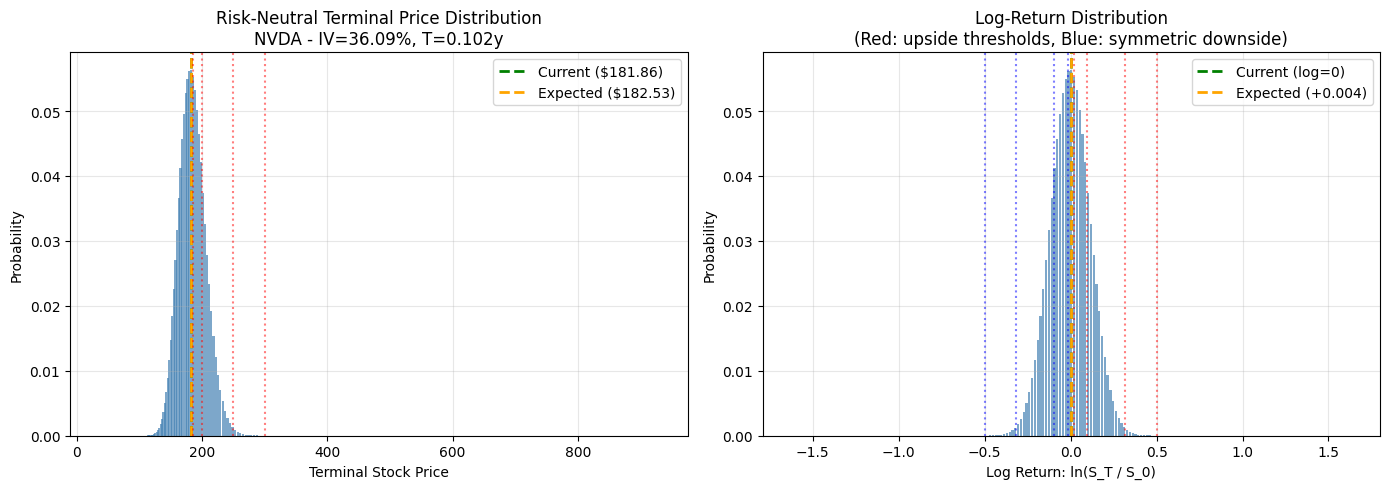

In [93]:
# Visualize the terminal price distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Price distribution (linear scale)
axes[0].bar(terminal_prices, terminal_probs, width=(terminal_prices.max() - terminal_prices.min()) / len(terminal_prices) * 0.8, alpha=0.7, color='steelblue')
axes[0].axvline(current_price, color='green', linestyle='--', linewidth=2, label=f'Current (${current_price:.2f})')
axes[0].axvline(expected_price, color='orange', linestyle='--', linewidth=2, label=f'Expected (${expected_price:.2f})')
for threshold in thresholds:
    axes[0].axvline(threshold, color='red', linestyle=':', alpha=0.5)
axes[0].set_xlabel('Terminal Stock Price')
axes[0].set_ylabel('Probability')
axes[0].set_title(f'Risk-Neutral Terminal Price Distribution\n{ticker} - IV={iv:.2%}, T={first_call["T"]:.3f}y')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Log-price distribution (shows symmetry/asymmetry)
log_prices = np.log(terminal_prices / current_price)
axes[1].bar(log_prices, terminal_probs, width=(log_prices.max() - log_prices.min()) / len(log_prices) * 0.8, alpha=0.7, color='steelblue')
axes[1].axvline(0, color='green', linestyle='--', linewidth=2, label='Current (log=0)')
axes[1].axvline(np.log(expected_price / current_price), color='orange', linestyle='--', linewidth=2, label=f'Expected ({np.log(expected_price/current_price):+.3f})')
for threshold in thresholds:
    log_thresh = np.log(threshold / current_price)
    axes[1].axvline(log_thresh, color='red', linestyle=':', alpha=0.5)
    axes[1].axvline(-log_thresh, color='blue', linestyle=':', alpha=0.5)
axes[1].set_xlabel('Log Return: ln(S_T / S_0)')
axes[1].set_ylabel('Probability')
axes[1].set_title('Log-Return Distribution\n(Red: upside thresholds, Blue: symmetric downside)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()